# Bed Frame Analysis with Home Assistant Events

This notebook uses the refactored Python modules for analyzing bed frame sensor data with Home Assistant events.

In [1]:
# Import required libraries and our custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Import our refactored modules
from movement_detection import MovementConfig
from ha_client import load_ha_events
from bed_frame_analysis import (
    load_sensor_data,
    analyze_all_events,
    print_analysis_summary
)
from visualization import plot_pitch_with_events, plot_velocity_profile

%matplotlib inline

In [2]:
# Load and examine sensor data
df = load_sensor_data('open-close.csv')

print(f"Loaded {len(df)} sensor readings")
print(f"Sensor time range: {df['sensor_timestamp'].min()} to {df['sensor_timestamp'].max()}")
print(f"Pitch range: {df['pitch'].min():.3f} to {df['pitch'].max():.3f} radians")

# Display first few rows
print("\nFirst 5 rows of data:")
display(df[['sensor_timestamp', 'pitch', 'roll', 'yaw']].head())

Loaded 1300 sensor readings
Sensor time range: 2025-08-20 23:20:38.261002800 to 2025-08-20 23:21:43.324575500
Pitch range: 0.046 to 1.029 radians

First 5 rows of data:


,sensor_timestamp,pitch,roll,yaw
0,2025-08-20 23:20:38.261002800,0.046891,-0.052862,1.493586
1,2025-08-20 23:20:38.311090700,0.046887,-0.052868,1.493576
2,2025-08-20 23:20:38.361177600,0.046875,-0.052863,1.493586
3,2025-08-20 23:20:38.411265800,0.046903,-0.052882,1.493555
4,2025-08-20 23:20:38.461352700,0.046925,-0.052870,1.493568


In [3]:
# Load Home Assistant events
ENTITY_ID = 'cover.bed_remote_head_position'
HA_URL = 'http://tvpi:8123'
TOKEN_PATH = '/run/secrets/home-assistant/token'

ha_events = load_ha_events(
    sensor_df=df,
    entity_id=ENTITY_ID,
    ha_url=HA_URL,
    token_path=TOKEN_PATH
)

print(f"Found {len(ha_events)} events within sensor data timeframe")
for event in ha_events:
    print(f"  {event['timestamp']}: {event['state']}")

Found 4 events within sensor data timeframe
  2025-08-20 23:20:45.443728: opening
  2025-08-20 23:21:05.458536: open
  2025-08-20 23:21:20.212801: closing
  2025-08-20 23:21:40.216318: closed


In [4]:
# Configure and run movement analysis
config = MovementConfig(
    window_seconds=20.0,          # Look for movement within 20 seconds
    movement_threshold=0.005,      # Radians/second to consider as "stopped"
    stability_time=0.5,            # Seconds of stability required to confirm stop
    start_movement_threshold=0.01  # Minimum change to detect movement has started
)

# Analyze all events
analysis = analyze_all_events(ha_events, df, config)

# Print detailed results
print_analysis_summary(analysis)

Movement Stop Analysis

Opening at 23:20:45.443
  Movement started after 1983 ms
  Stopped at: 1.027 rad (up, Δ=0.980) at 23:21:02.302
  Total time to stop: 16859 ms

Closing at 23:21:20.212
  Movement started after 172 ms
  Stopped at: 0.046 rad (down, Δ=-0.980) at 23:21:32.906
  Total time to stop: 12694 ms

Summary Statistics
--------------------------------------------------
Opening commands: 1
  Average start delay: 1983 ms
  Average time to stop: 16859 ms
  Min time to stop: 16859 ms
  Max time to stop: 16859 ms

Closing commands: 1
  Average start delay: 172 ms
  Average time to stop: 12694 ms
  Min time to stop: 12694 ms
  Max time to stop: 12694 ms


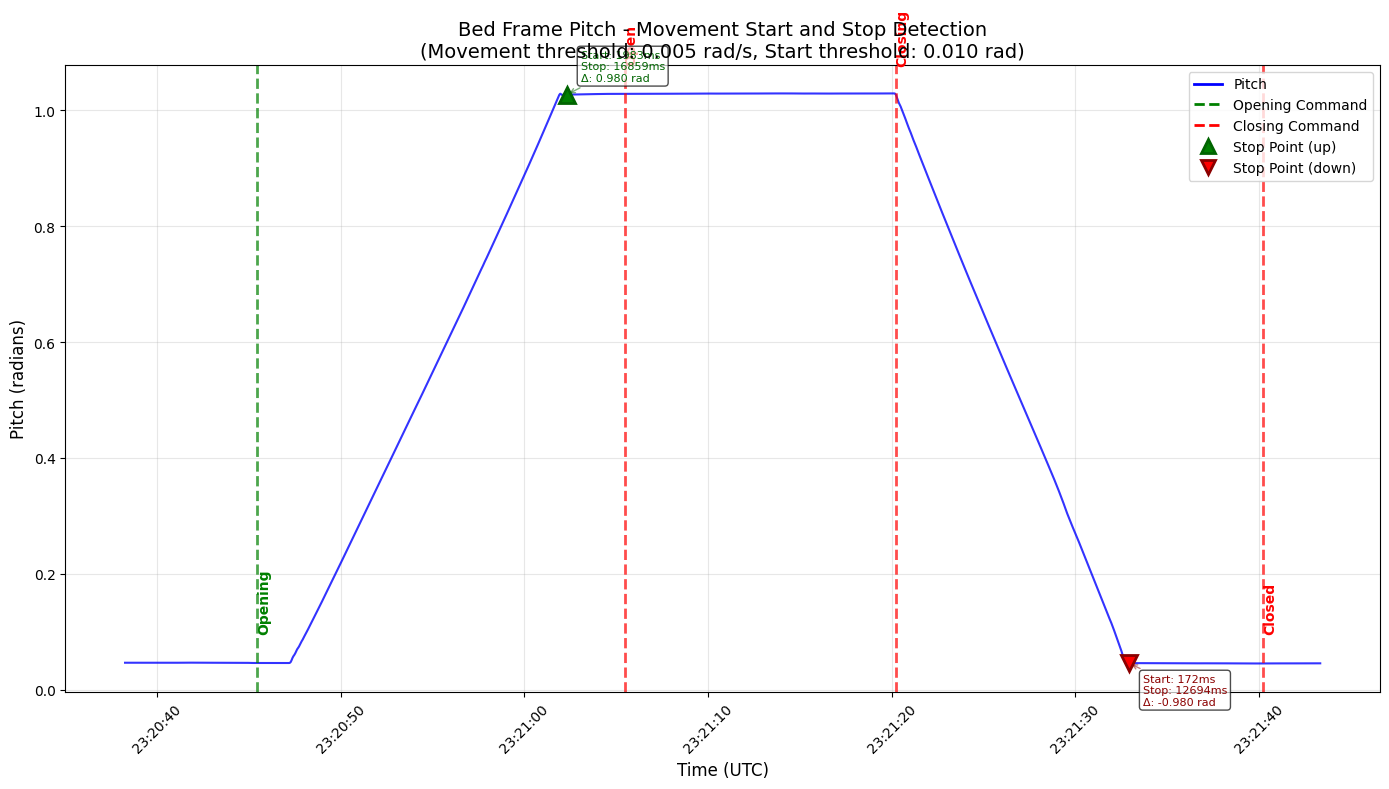


Detected 2 movement stop points
Average start delay: 1077 ms
Average stop delay: 14776 ms


In [5]:
# Create main visualization
fig = plot_pitch_with_events(df, ha_events, analysis, figsize=(14, 8))
plt.show()

# Print summary of detected stop points
if analysis['results']:
    print(f"\nDetected {len(analysis['results'])} movement stop points")
    avg_start_delay = np.mean([r['start_delay_ms'] for r in analysis['results']])
    avg_stop_delay = np.mean([r['stop_delay_ms'] for r in analysis['results']])
    print(f"Average start delay: {avg_start_delay:.0f} ms")
    print(f"Average stop delay: {avg_stop_delay:.0f} ms")


Event 1: Opening at 23:20:45


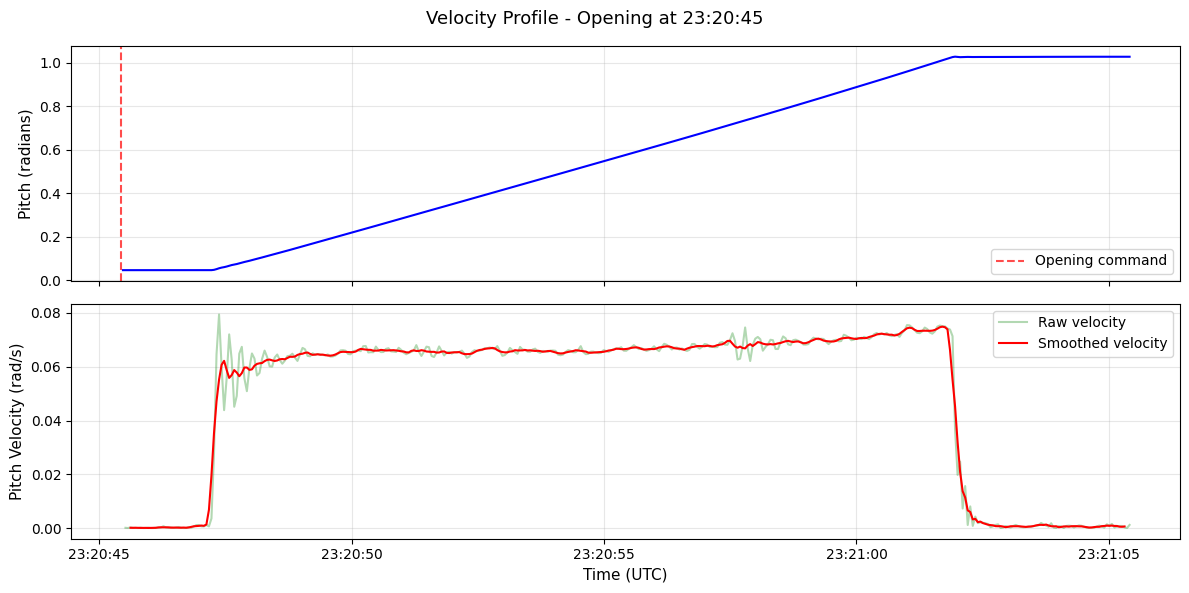


Event 2: Open at 23:21:05


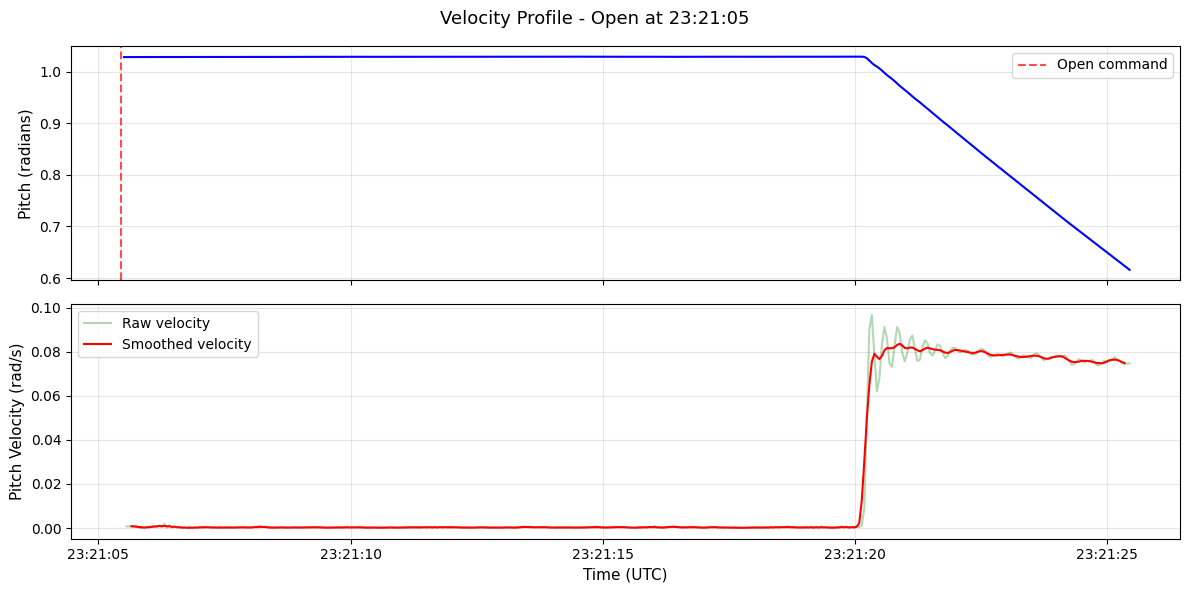

In [6]:
# Plot velocity profiles for individual events
for i, event in enumerate(ha_events[:2]):  # Show first 2 events
    print(f"\nEvent {i+1}: {event['state'].capitalize()} at {event['timestamp'].strftime('%H:%M:%S')}")
    fig = plot_velocity_profile(event, df, config.window_seconds, figsize=(12, 6))
    plt.show()

In [7]:
# Interactive exploration - Try different configurations
print("Testing different movement detection parameters:\n")

configs_to_test = [
    ("Sensitive", MovementConfig(movement_threshold=0.003, stability_time=0.3)),
    ("Default", MovementConfig()),
    ("Less Sensitive", MovementConfig(movement_threshold=0.008, stability_time=0.7)),
]

comparison_results = []

for name, test_config in configs_to_test:
    test_analysis = analyze_all_events(ha_events, df, test_config)
    
    print(f"{name} Configuration:")
    print(f"  Movement threshold: {test_config.movement_threshold:.3f} rad/s")
    print(f"  Stability time: {test_config.stability_time:.1f} s")
    
    if test_analysis['results']:
        avg_stop = np.mean([r['stop_delay_ms'] for r in test_analysis['results']])
        print(f"  Detected events: {len(test_analysis['results'])}")
        print(f"  Avg stop delay: {avg_stop:.0f} ms")
    else:
        print(f"  No events detected")
    
    comparison_results.append((name, test_config, test_analysis))
    print()

Testing different movement detection parameters:

Sensitive Configuration:
  Movement threshold: 0.003 rad/s
  Stability time: 0.3 s
  Detected events: 2
  Avg stop delay: 14826 ms

Default Configuration:
  Movement threshold: 0.005 rad/s
  Stability time: 0.5 s
  Detected events: 2
  Avg stop delay: 14776 ms

Less Sensitive Configuration:
  Movement threshold: 0.008 rad/s
  Stability time: 0.7 s
  Detected events: 2
  Avg stop delay: 14726 ms



In [8]:
# Export results for further analysis
if analysis['results']:
    # Convert results to DataFrame for easy manipulation
    results_df = pd.DataFrame(analysis['results'])
    
    # Add derived columns
    results_df['movement_duration_ms'] = results_df['stop_delay_ms'] - results_df['start_delay_ms']
    results_df['pitch_change_abs'] = results_df['pitch_change'].abs()
    
    print("Analysis Results Summary:")
    print(results_df[['event_state', 'start_delay_ms', 'stop_delay_ms', 
                      'movement_duration_ms', 'pitch_change', 'direction']])
    
    # Save to CSV if needed
    # results_df.to_csv('movement_analysis_results.csv', index=False)
    # print("\nResults saved to 'movement_analysis_results.csv'")

Analysis Results Summary:
  event_state  start_delay_ms  stop_delay_ms  movement_duration_ms  \
0     opening        1983.268      16859.224             14875.956   
1     closing         171.702      12693.565             12521.863   

   pitch_change direction  
0      0.980277        up  
1     -0.979609      down  
